In [2]:
import sys
sys.path.insert(0, "/home/vanessa/hulk/cocpit") 

import matplotlib.pyplot as plt
import seaborn as sns
import torch
import cocpit
import numpy as np
from cocpit import config as config
sns.set_style("whitegrid")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
plt_params = {
    "axes.labelsize": "xx-large",
    "axes.titlesize": "xx-large",
    "xtick.labelsize": "xx-large",
    "ytick.labelsize": "xx-large",
    "legend.title_fontsize": 12,
}
plt.rcParams["font.family"] = "serif"
plt.rcParams.update(plt_params)

In [4]:
#  make predictions on each batch of images,
#  and concatenate the precitions across batches
p = cocpit.predictions.LoaderPredictions()
with torch.no_grad():
    for fold in range(config.KFOLD+1):
        model = p.load_model(fold)
        val_loader = p.load_val_loader(fold)
        for ((imgs, labels, paths), batch) in val_loader:
            b = cocpit.predictions.BatchPredictions(imgs, model)
            b.find_max_preds()
            b.top_k_preds(len(config.CLASS_NAMES))
            p.append_batch(b, paths, labels)
p.concatenate_loader_vars()


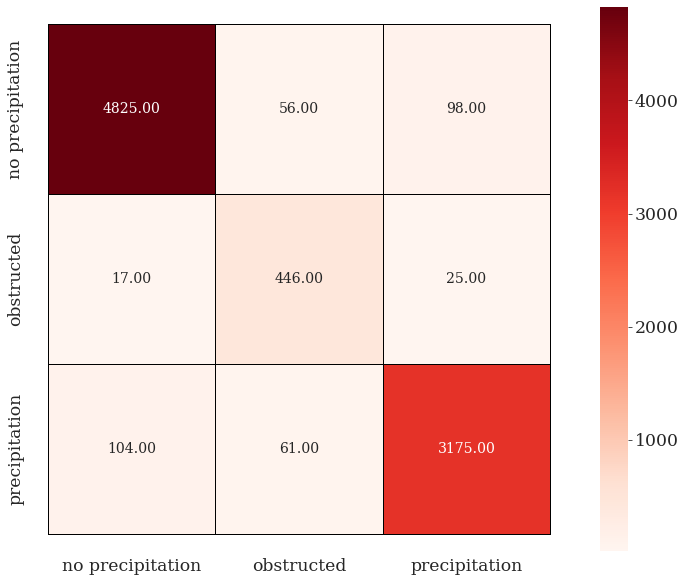

array([[4825,   56,   98],
       [  17,  446,   25],
       [ 104,   61, 3175]])

In [8]:
# plot/save conf matrix from one val_loader
# don't normalize (show magnitude of predictions per class)
save_name = "/ai2es/plots/conf_matrix_codebook_v0.0.0.pdf"

cm = cocpit.plotting_scripts.confusion_matrix.conf_matrix(p.labels, p.max_preds, norm=None, save_fig=False)
cm

In [11]:
def model_diagnostic_stats(confusion_matrix):
    tp = confusion_matrix[1,1]
    tn = confusion_matrix[0,0]
    fp = confusion_matrix[0,1]
    fn = confusion_matrix[1,0]
    
    p = tp + fn
    n = fp + tn
    pp = tp + fp
    pn = fn + tn
    
    diagnostic_dict = {   
    'recall' : tp/p,
    'false_neg_rate' : fn/p,
    'false_pos_rate' : fp/n,
    'true_neg_rate' : tn/n,
    'positive_liklihood_ratio' : (tp/p)/(fp/n),
    'neg_liklihood_rate' : (fn/p)/(tn/n),
    'precision' : tp/pp,
    'false_omission_rate' : fn/pn,
    'false_discovery_rate' : fp/pp,
    'neg_pred_value' : tn/pn,
    'markedness' : (tp/pp)+(tn/pn)-1,
    'diagnostic_odds_ration' : ((tp/p)/(fp/n))/( (fn/p)/(tn/n)),
    'informedness' : (tp/p)+(tn/n)-1,
    'prevalence' : p/(p+n),
    'accuracy' : (tp+tn)/(p+n),
    'balanced_accuracy' : ((tp/p)+(tn/n))/2,
    'F1_score' : 2*tp/(2*tp+fp+fn),
    'jaccard_index' : tp/(tp+fn+fp),
    }
    
    return diagnostic_dict

model_diagnostic_stats(cm)


{'recall': 0.9632829373650108,
 'false_neg_rate': 0.0367170626349892,
 'false_pos_rate': 0.011473058799426348,
 'true_neg_rate': 0.9885269412005736,
 'positive_liklihood_ratio': 83.96042887997531,
 'neg_liklihood_rate': 0.0371432088541725,
 'precision': 0.8884462151394422,
 'false_omission_rate': 0.003510945890128046,
 'false_discovery_rate': 0.11155378486055777,
 'neg_pred_value': 0.996489054109872,
 'markedness': 0.8849352692493142,
 'diagnostic_odds_ration': 2260.4516806722686,
 'informedness': 0.9518098785655844,
 'prevalence': 0.08663922155688623,
 'accuracy': 0.9863398203592815,
 'balanced_accuracy': 0.9759049392827922,
 'F1_score': 0.9243523316062177,
 'jaccard_index': 0.859344894026975}